In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
BATCH_SIZE = 100

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Baseline1(nn.Module):
    def __init__(self):
        super(Baseline1, self).__init__()

        self.d1 = nn.Linear(32 * 32 * 3, 30)
        self.d2 = nn.Linear(30, 10)

    def forward(self, x):

        x = x.flatten(start_dim = 1)

        x = self.d1(x)
        x = F.relu(x)

        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out


class Baseline2(nn.Module):
    def __init__(self):
        super(Baseline2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [6]:
# Baseline1

learning_rate = 0.001
num_epochs = 50

losses_baseline1 = list()
accuracies_baseline1 = list()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Baseline1()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
        
        
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / len(trainloader), train_acc/len(trainloader)))
    losses_baseline1.append(train_running_loss/len(trainloader))
    accuracies_baseline1.append(train_acc/len(trainloader))

test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/(i+1)))

Epoch: 0 | Loss: 2.2500 | Train Accuracy: 20.44
Epoch: 1 | Loss: 2.1951 | Train Accuracy: 26.52
Epoch: 2 | Loss: 2.1750 | Train Accuracy: 28.41
Epoch: 3 | Loss: 2.1608 | Train Accuracy: 30.11
Epoch: 4 | Loss: 2.1514 | Train Accuracy: 30.89
Epoch: 5 | Loss: 2.1457 | Train Accuracy: 31.60
Epoch: 6 | Loss: 2.1383 | Train Accuracy: 32.36
Epoch: 7 | Loss: 2.1346 | Train Accuracy: 32.52
Epoch: 8 | Loss: 2.1311 | Train Accuracy: 33.01
Epoch: 9 | Loss: 2.1274 | Train Accuracy: 33.35
Epoch: 10 | Loss: 2.1240 | Train Accuracy: 33.42
Epoch: 11 | Loss: 2.1208 | Train Accuracy: 33.87
Epoch: 12 | Loss: 2.1173 | Train Accuracy: 34.19
Epoch: 13 | Loss: 2.1175 | Train Accuracy: 34.08
Epoch: 14 | Loss: 2.1121 | Train Accuracy: 34.70
Epoch: 15 | Loss: 2.1109 | Train Accuracy: 34.87
Epoch: 16 | Loss: 2.1085 | Train Accuracy: 35.17
Epoch: 17 | Loss: 2.1074 | Train Accuracy: 35.09
Epoch: 18 | Loss: 2.1042 | Train Accuracy: 35.57
Epoch: 19 | Loss: 2.1028 | Train Accuracy: 35.55
Epoch: 20 | Loss: 2.1018 | Tra

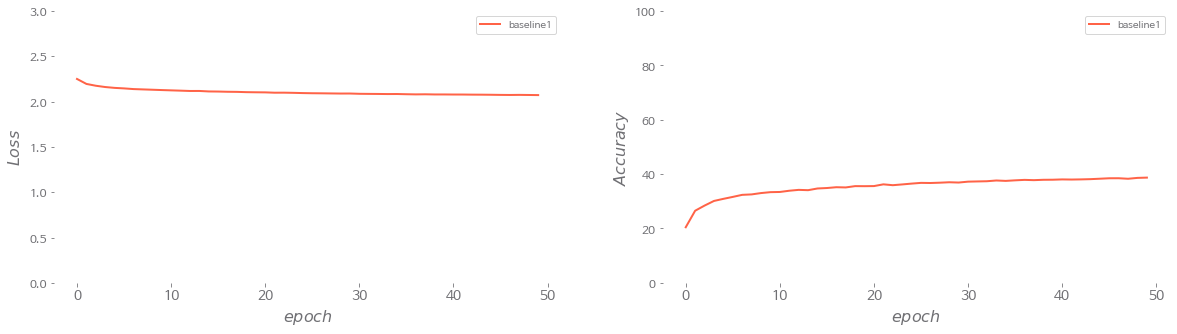

In [36]:
#Plot result

# baseline1 : losses_baseline1 / accuracies_baseline1


import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1, 2, 1)
plt.plot(losses_baseline1, label = 'baseline1', color='tomato')
plt.legend()
plt.grid()
plt.ylabel("$Loss$", fontsize=16)
plt.xlabel("$epoch$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.ylim([0, 3])

plt.subplot(1, 2, 2)
plt.plot(accuracies_baseline1, label = 'baseline1', color='tomato')

plt.grid()
plt.ylabel("$Accuracy$", fontsize=16)
plt.xlabel("$epoch$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(np.arange(0, 100))
plt.ylim([0, 100])



plt.legend()
plt.show()

In [7]:
# Baseline2

learning_rate = 0.001
num_epochs = 50

losses_baseline2 = list()
accuracies_baseline2 = list()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Which model
model = Baseline2()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
        
        
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / len(trainloader), train_acc/len(trainloader)))
    losses_baseline2.append(train_running_loss/len(trainloader))
    accuracies_baseline2.append(train_acc/len(trainloader))

test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/(i+1)))

Epoch: 0 | Loss: 2.2361 | Train Accuracy: 16.84
Epoch: 1 | Loss: 2.0070 | Train Accuracy: 26.96
Epoch: 2 | Loss: 1.8703 | Train Accuracy: 32.11
Epoch: 3 | Loss: 1.7551 | Train Accuracy: 35.32
Epoch: 4 | Loss: 1.6831 | Train Accuracy: 38.06
Epoch: 5 | Loss: 1.6337 | Train Accuracy: 40.24
Epoch: 6 | Loss: 1.5977 | Train Accuracy: 41.45
Epoch: 7 | Loss: 1.5618 | Train Accuracy: 43.03
Epoch: 8 | Loss: 1.5320 | Train Accuracy: 44.32
Epoch: 9 | Loss: 1.4959 | Train Accuracy: 45.99
Epoch: 10 | Loss: 1.4717 | Train Accuracy: 46.63
Epoch: 11 | Loss: 1.4404 | Train Accuracy: 48.30
Epoch: 12 | Loss: 1.4195 | Train Accuracy: 49.01
Epoch: 13 | Loss: 1.3995 | Train Accuracy: 49.79
Epoch: 14 | Loss: 1.3713 | Train Accuracy: 50.78
Epoch: 15 | Loss: 1.3593 | Train Accuracy: 51.33
Epoch: 16 | Loss: 1.3407 | Train Accuracy: 52.06
Epoch: 17 | Loss: 1.3202 | Train Accuracy: 52.88
Epoch: 18 | Loss: 1.3044 | Train Accuracy: 53.48
Epoch: 19 | Loss: 1.2956 | Train Accuracy: 53.69
Epoch: 20 | Loss: 1.2790 | Tra

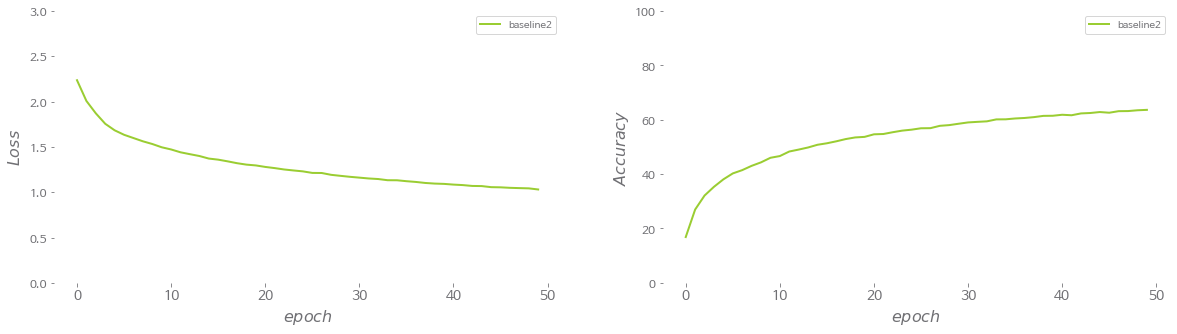

In [37]:
#Plot result

# baseline2 : losses_baseline2 / accuracies_baseline2


import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1, 2, 1)
plt.plot(losses_baseline2, label = 'baseline2', color='yellowgreen')
plt.legend()
plt.grid()
plt.ylabel("$Loss$", fontsize=16)
plt.xlabel("$epoch$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.ylim([0, 3])

plt.subplot(1, 2, 2)
plt.plot(accuracies_baseline2, label = 'baseline2', color='yellowgreen')

plt.grid()
plt.ylabel("$Accuracy$", fontsize=16)
plt.xlabel("$epoch$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(np.arange(0, 100))
plt.ylim([0, 100])



plt.legend()
plt.show()

In [8]:
class JHNet_1(nn.Module):
    def __init__(self):
        super(JHNet_1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(256, 512) 
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5, inplace=False)
        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(self.dropout(F.relu(self.conv4(x))))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [9]:
# JHNet_1

learning_rate = 0.001
num_epochs = 50

losses_jhnet1 = list()
accuracies_jhnet1 = list()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Which model
model = JHNet_1()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
        
        
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / len(trainloader), train_acc/len(trainloader)))
    losses_jhnet1.append(train_running_loss/len(trainloader))
    accuracies_jhnet1.append(train_acc/len(trainloader))

test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/(i+1)))

Epoch: 0 | Loss: 2.3003 | Train Accuracy: 11.09
Epoch: 1 | Loss: 2.2613 | Train Accuracy: 15.37
Epoch: 2 | Loss: 2.0896 | Train Accuracy: 21.01
Epoch: 3 | Loss: 1.9353 | Train Accuracy: 26.04
Epoch: 4 | Loss: 1.8323 | Train Accuracy: 29.81
Epoch: 5 | Loss: 1.7711 | Train Accuracy: 32.66
Epoch: 6 | Loss: 1.7096 | Train Accuracy: 35.35
Epoch: 7 | Loss: 1.6562 | Train Accuracy: 37.78
Epoch: 8 | Loss: 1.5982 | Train Accuracy: 39.78
Epoch: 9 | Loss: 1.5582 | Train Accuracy: 41.81
Epoch: 10 | Loss: 1.5034 | Train Accuracy: 44.21
Epoch: 11 | Loss: 1.4566 | Train Accuracy: 45.73
Epoch: 12 | Loss: 1.4181 | Train Accuracy: 47.70
Epoch: 13 | Loss: 1.3783 | Train Accuracy: 49.31
Epoch: 14 | Loss: 1.3414 | Train Accuracy: 50.91
Epoch: 15 | Loss: 1.3082 | Train Accuracy: 52.38
Epoch: 16 | Loss: 1.2686 | Train Accuracy: 53.77
Epoch: 17 | Loss: 1.2348 | Train Accuracy: 55.29
Epoch: 18 | Loss: 1.2058 | Train Accuracy: 56.52
Epoch: 19 | Loss: 1.1783 | Train Accuracy: 57.59
Epoch: 20 | Loss: 1.1527 | Tra

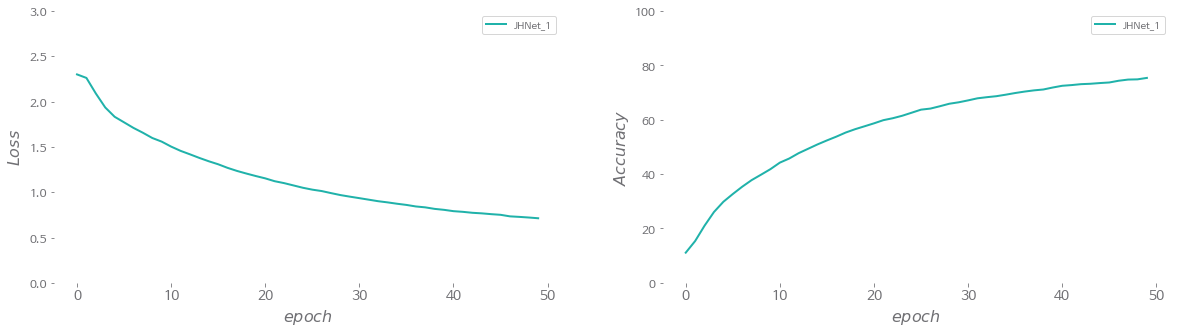

In [38]:
#Plot result

# jhnet1 : losses_jhnet1 / accuracies_jhnet1


import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1, 2, 1)
# plt.title("$Loss$", fontsize=18)
plt.plot(losses_jhnet1, label = 'JHNet_1', color='lightseagreen')
plt.legend()
plt.grid()
plt.ylabel("$Loss$", fontsize=16)
plt.xlabel("$epoch$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.ylim([0, 3])

plt.subplot(1, 2, 2)
plt.plot(accuracies_jhnet1, label = 'JHNet_1', color='lightseagreen')

plt.grid()
plt.ylabel("$Accuracy$", fontsize=16)
plt.xlabel("$epoch$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(np.arange(0, 100))
plt.ylim([0, 100])



plt.legend()
plt.show()

In [10]:
class JHNet_2(nn.Module):
    def __init__(self):
        super(JHNet_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(256, 512, 3)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(self.conv2(F.relu(self.bn1(x))))
        x = self.pool(self.conv3(F.relu(self.bn2(x))))
        x = self.pool(self.conv4(F.relu(self.bn3(x))))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [11]:
# JHNet_2

import torch.optim.lr_scheduler

# 모델, 정규화방법 등 더 수정 

learning_rate = 0.001
num_epochs = 50

losses_jhnet2 = list()
accuracies_jhnet2 = list()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Which model
model = JHNet_2()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
schedular = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs, eta_min=0) # schedular add

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    schedular.step()
        
        
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / len(trainloader), train_acc/len(trainloader)))
    losses_jhnet2.append(train_running_loss/len(trainloader))
    accuracies_jhnet2.append(train_acc/len(trainloader))

test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/(i+1)))

Epoch: 0 | Loss: 1.6888 | Train Accuracy: 38.76
Epoch: 1 | Loss: 1.2918 | Train Accuracy: 53.64
Epoch: 2 | Loss: 1.1229 | Train Accuracy: 60.17
Epoch: 3 | Loss: 1.0095 | Train Accuracy: 64.47
Epoch: 4 | Loss: 0.9320 | Train Accuracy: 67.42
Epoch: 5 | Loss: 0.8687 | Train Accuracy: 69.63
Epoch: 6 | Loss: 0.8182 | Train Accuracy: 71.46
Epoch: 7 | Loss: 0.7792 | Train Accuracy: 72.88
Epoch: 8 | Loss: 0.7327 | Train Accuracy: 74.69
Epoch: 9 | Loss: 0.7050 | Train Accuracy: 75.47
Epoch: 10 | Loss: 0.6806 | Train Accuracy: 76.46
Epoch: 11 | Loss: 0.6535 | Train Accuracy: 77.45
Epoch: 12 | Loss: 0.6335 | Train Accuracy: 78.10
Epoch: 13 | Loss: 0.6090 | Train Accuracy: 78.94
Epoch: 14 | Loss: 0.5881 | Train Accuracy: 79.64
Epoch: 15 | Loss: 0.5726 | Train Accuracy: 80.13
Epoch: 16 | Loss: 0.5578 | Train Accuracy: 80.88
Epoch: 17 | Loss: 0.5443 | Train Accuracy: 81.19
Epoch: 18 | Loss: 0.5276 | Train Accuracy: 81.69
Epoch: 19 | Loss: 0.5161 | Train Accuracy: 82.11
Epoch: 20 | Loss: 0.4989 | Tra

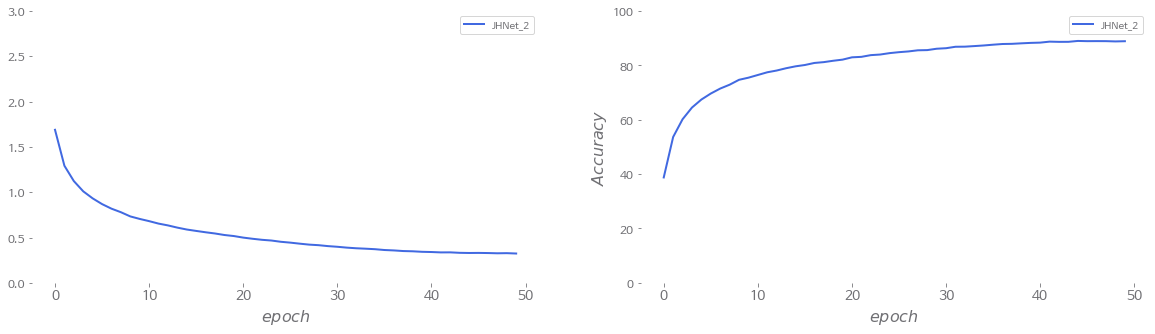

In [39]:
#Plot result

# jhnet2 : losses_jhnet2 / accuracies_jhnet2


import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1, 2, 1)
# plt.title("$Loss$", fontsize=18)
plt.plot(losses_jhnet2, label = 'JHNet_2', color='royalblue')
plt.legend()
plt.grid()
plt.xlabel("$epoch$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.ylim([0, 3])

plt.subplot(1, 2, 2)
plt.plot(accuracies_jhnet2, label = 'JHNet_2', color='royalblue')

plt.grid()
plt.ylabel("$Accuracy$", fontsize=16)
plt.xlabel("$epoch$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(np.arange(0, 100))
plt.ylim([0, 100])



plt.legend()
plt.show()

In [12]:
class JHNet_3(nn.Module):
    def __init__(self):
        super(JHNet_3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(256, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)
        
    
    def forward(self, x):
        x = self.pool(self.conv1(x)) 
        out = self.conv2(F.relu(self.bn1(x))) 
        out = self.conv3(F.relu(self.bn2(out)))
        out = self.conv4(F.relu(self.bn3(out)))
        x = out + x 
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
    
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [13]:
# JHNet_3


learning_rate = 0.001
num_epochs = 50

losses_jhnet3 = list()
accuracies_jhnet3 = list()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Which model
model = JHNet_3()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
schedular = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs, eta_min=0) # schedular add

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    schedular.step()
        
        
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / len(trainloader), train_acc/len(trainloader)))
    losses_jhnet3.append(train_running_loss/len(trainloader))
    accuracies_jhnet3.append(train_acc/len(trainloader))

test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/(i+1)))

Epoch: 0 | Loss: 1.6153 | Train Accuracy: 41.76
Epoch: 1 | Loss: 1.2846 | Train Accuracy: 53.89
Epoch: 2 | Loss: 1.1261 | Train Accuracy: 60.13
Epoch: 3 | Loss: 1.0291 | Train Accuracy: 63.59
Epoch: 4 | Loss: 0.9665 | Train Accuracy: 65.78
Epoch: 5 | Loss: 0.9164 | Train Accuracy: 67.79
Epoch: 6 | Loss: 0.8759 | Train Accuracy: 69.21
Epoch: 7 | Loss: 0.8394 | Train Accuracy: 70.57
Epoch: 8 | Loss: 0.8066 | Train Accuracy: 71.72
Epoch: 9 | Loss: 0.7779 | Train Accuracy: 72.74
Epoch: 10 | Loss: 0.7441 | Train Accuracy: 74.09
Epoch: 11 | Loss: 0.7185 | Train Accuracy: 74.89
Epoch: 12 | Loss: 0.6999 | Train Accuracy: 75.47
Epoch: 13 | Loss: 0.6789 | Train Accuracy: 76.46
Epoch: 14 | Loss: 0.6637 | Train Accuracy: 76.95
Epoch: 15 | Loss: 0.6359 | Train Accuracy: 77.97
Epoch: 16 | Loss: 0.6240 | Train Accuracy: 78.38
Epoch: 17 | Loss: 0.6112 | Train Accuracy: 78.97
Epoch: 18 | Loss: 0.5942 | Train Accuracy: 79.24
Epoch: 19 | Loss: 0.5783 | Train Accuracy: 79.86
Epoch: 20 | Loss: 0.5729 | Tra

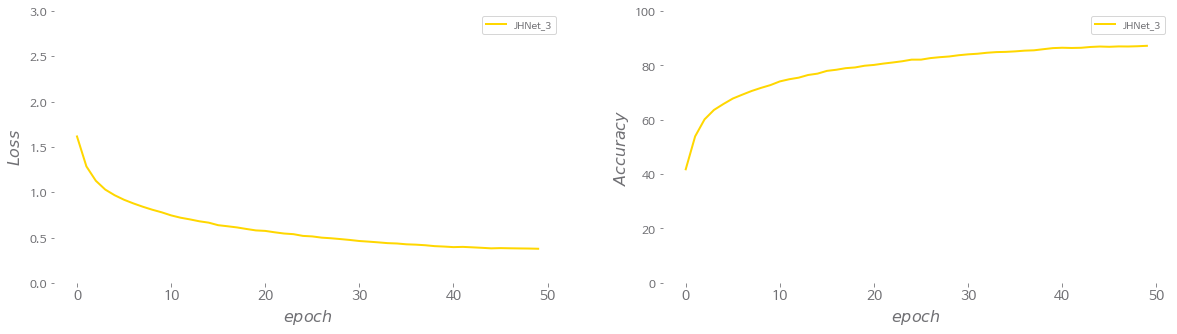

In [40]:
#Plot result

# jhnet3 : losses_jhnet3 / accuracies_jhnet3


import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1, 2, 1)
# plt.title("$Loss$", fontsize=18)
plt.plot(losses_jhnet3, label = 'JHNet_3', color='gold')
plt.legend()
plt.grid()
plt.ylabel("$Loss$", fontsize=16)
plt.xlabel("$epoch$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.ylim([0, 3])

plt.subplot(1, 2, 2)
plt.plot(accuracies_jhnet3, label = 'JHNet_3', color='gold')

plt.grid()
plt.ylabel("$Accuracy$", fontsize=16)
plt.xlabel("$epoch$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(np.arange(0, 100))
plt.ylim([0, 100])



plt.legend()
plt.show()

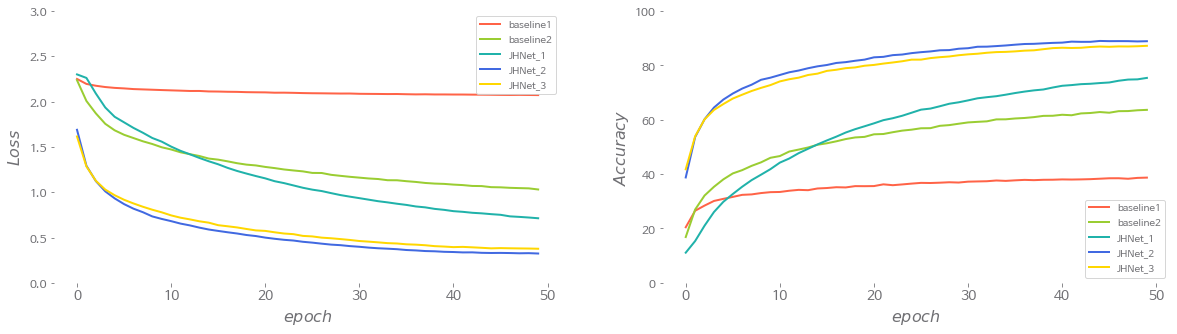

In [41]:
#Plot result

# baseline1 : losses_baseline1 / accuracies_baseline1
# baseline2 : losses_baseline2 / accuracies_baseline2
# jhnet1 : losses_jhnet1 / accuracies_jhnet1
# jhnet2 : losses_jhnet2 / accuracies_jhnet2
# jhnet3 : losses_jhnet3 / accuracies_jhnet3


import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1, 2, 1)
# plt.title("$Loss$", fontsize=18)
plt.plot(losses_baseline1, label = 'baseline1', color='tomato')
plt.plot(losses_baseline2, label = 'baseline2', color='yellowgreen')
plt.plot(losses_jhnet1, label = 'JHNet_1', color='lightseagreen')
plt.plot(losses_jhnet2, label = 'JHNet_2', color='royalblue')
plt.plot(losses_jhnet3, label = 'JHNet_3', color='gold')
plt.legend()
plt.grid()
plt.ylabel("$Loss$", fontsize=16)
plt.xlabel("$epoch$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.ylim([0, 3])

plt.subplot(1, 2, 2)
plt.plot(accuracies_baseline1, label = 'baseline1', color='tomato')
plt.plot(accuracies_baseline2, label = 'baseline2', color='yellowgreen')
plt.plot(accuracies_jhnet1, label = 'JHNet_1', color='lightseagreen')
plt.plot(accuracies_jhnet2, label = 'JHNet_2', color='royalblue')
plt.plot(accuracies_jhnet3, label = 'JHNet_3', color='gold')

plt.grid()
plt.ylabel("$Accuracy$", fontsize=16)
plt.xlabel("$epoch$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(np.arange(0, 100))
plt.ylim([0, 100])



plt.legend()
plt.show()